In [48]:
import pandas as pd
from scipy import stats

import numpy as np

In [49]:
# file has no header

df = pd.read_csv('Data collection.csv',  header=None)
# rename columns
df.columns = ['path', 'into', 'question', 'iteration', 'name', 'model', 'userAnswer', 'modelAnswer', 'stringefied_prompt']
df.head()

,path,into,question,iteration,name,model,userAnswer,modelAnswer,stringefied_prompt
0,question_1/AfD-AfD/out_41-mini_v1_3.json,intro,Auf einer Skala von 1 bis 7: Wie sehr stimmst ...,0,Maxim Kallert,person_open_router_completion,6,3,"[{""role"": ""system"", ""content"": ""The scenario i..."
1,question_0/Bündnis_90_Die_Grünen-FDP/out_41-mi...,intro,Auf einer Skala von 1 bis 7: Wie sehr stimmst ...,8,Centa Zorbach,person_open_router_completion,5,5,"[{""role"": ""system"", ""content"": ""Scenario: Du d..."
2,question_1/SPD-AfD/out_41-mini_v1_0.json,intro,Auf einer Skala von 1 bis 7: Wie sehr stimmst ...,16,Bernd Textor,person_open_router_completion,6,6,"[{""role"": ""system"", ""content"": ""The scenario i..."
3,question_0/Bündnis_90_Die_Grünen-keine_Partei/...,intro,Auf einer Skala von 1 bis 7: Wie sehr stimmst ...,20,Hermann Josef Hermighausen-Stahr,person_open_router_completion,7,6,"[{""role"": ""system"", ""content"": ""Scenario: Du d..."
4,question_4/SPD-SPD/out_41-mini_v0_1.json,intro,Auf einer Skala von 1 bis 7: Wie sehr stimmst ...,0,Benita Heß,person_open_router_completion,6,6,"[{""role"": ""system"", ""content"": ""Scenario: Du d..."


In [50]:
# mean absolute error between userAnswer and modelAnswer
df['abs_error'] = (df['userAnswer'] - df['modelAnswer']).abs()
mean_abs_error = df['abs_error'].mean()
print(f'Mean Absolute Error: {mean_abs_error}')



# Wilcoxon signed-rank test to see if userAnswer and modelAnswer are significantly different
w_stat, p_value = stats.wilcoxon(df['userAnswer'], df['modelAnswer'], alternative='two-sided')
print(f'Wilcoxon statistic: {w_stat}, P-value: {p_value}')


Mean Absolute Error: 0.75
Wilcoxon statistic: 223.0, P-value: 0.03779757285767982


                                            question  abs_error
0  Auf einer Skala von 1 bis 7: Wie sehr stimmst ...   0.812500
1  Auf einer Skala von 1 bis 7: Wie sehr stimmst ...   0.583333
2  Auf einer Skala von 1 bis 7: Wie sehr stimmst ...   0.933333
3  Auf einer Skala von 1 bis 7: Wie sehr stimmst ...   0.333333
4  Auf einer Skala von 1 bis 7: Wie sehr stimmst ...   0.818182


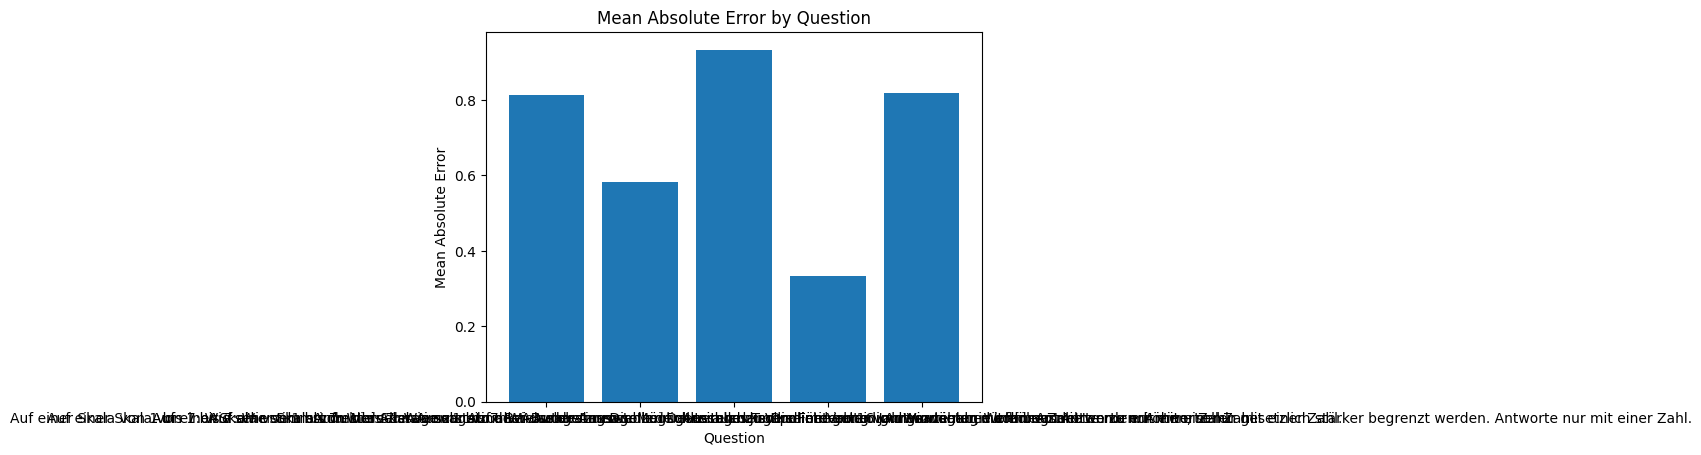

--- Question Analysis ---
Question: Auf einer Skala von 1 bis 7: Wie sehr stimmst du der Aussage zu: Auf allen Autobahnen soll ein generelles Tempolimit gelten. Antworte nur mit einer Zahl.
length: 16
Wilcoxon statistic: 4.0, P-value: 0.012613437305241745
Mean Absolute Error: 0.8125
---
--- Question Analysis ---
Question: Auf einer Skala von 1 bis 7: Wie sehr stimmst du der Aussage zu: Bei Bundestagswahlen sollen auch Jugendliche ab 16 Jahren wählen dürfen. Antworte nur mit einer Zahl.
length: 12
Wilcoxon statistic: 4.0, P-value: 0.125
Mean Absolute Error: 0.5833333333333334
---
--- Question Analysis ---
Question: Auf einer Skala von 1 bis 7: Wie sehr stimmst du der Aussage zu: Deutschland soll seine Verteidigungsausgaben erhöhen. Antworte nur mit einer Zahl.
length: 15
Wilcoxon statistic: 25.0, P-value: 0.7911530821281239
Mean Absolute Error: 0.9333333333333333
---
--- Question Analysis ---
Question: Auf einer Skala von 1 bis 7: Wie sehr stimmst du der Aussage zu: Die Förderung von Wi

In [51]:
# group data by question and calculate mean absolute error for each question
grouped = df.groupby('question')['abs_error'].mean().reset_index()  
print(grouped)

# visualize the mean absolute error for each question
import matplotlib.pyplot as plt
plt.bar(grouped['question'], grouped['abs_error'])
plt.xlabel('Question')
plt.ylabel('Mean Absolute Error')
plt.title('Mean Absolute Error by Question')
plt.show()


# Wilcoxon test for each question and Bonferroni correction
questions = []
ns = []
w_stats = []
p_values = []
for question, group in df.groupby('question'):
    questions.append(question)
    ns.append(len(group))
    print(f'--- Question Analysis ---')
    print(f'Question: {question}')
    print(f'length: {len(group)}')
    # require at least one non-zero difference; wilcoxon may raise if all diffs are zero or insufficient
    try:
        w_stat, p_value = stats.wilcoxon(group['userAnswer'], group['modelAnswer'], alternative='two-sided')
    except Exception:
        w_stat, p_value = (None, None)
    w_stats.append(w_stat)
    p_values.append(p_value)
    print(f'Wilcoxon statistic: {w_stat}, P-value: {p_value}')
    print('Mean Absolute Error:', group['abs_error'].mean())
    print('---')

# Bonferroni correction
num_tests = len([p for p in p_values if p is not None])
p_bonf = [min(p * num_tests, 1.0) if p is not None else None for p in p_values]
significant = [(p_adj is not None) and (p_adj < 0.05) for p_adj in p_bonf]
results_df = pd.DataFrame({
    'question': questions,
    'n': ns,
    'wilcoxon_stat': w_stats,
    'p_value': p_values,
    'p_bonferroni': p_bonf,
    'significant_bonferroni': significant
})
print('\nBonferroni-corrected results (alpha=0.05):')
print(results_df.sort_values('p_bonferroni'))


['Auf einer Skala von 1 bis 7: Wie sehr stimmst du der Aussage zu: Auf allen Autobahnen soll ein generelles Tempolimit gelten. Antworte nur mit einer Zahl.'
 'Auf einer Skala von 1 bis 7: Wie sehr stimmst du der Aussage zu: Bei Bundestagswahlen sollen auch Jugendliche ab 16 Jahren wählen dürfen. Antworte nur mit einer Zahl.'
 'Auf einer Skala von 1 bis 7: Wie sehr stimmst du der Aussage zu: Deutschland soll seine Verteidigungsausgaben erhöhen. Antworte nur mit einer Zahl.'
 'Auf einer Skala von 1 bis 7: Wie sehr stimmst du der Aussage zu: Die Förderung von Windenergie soll beendet werden. Antworte nur mit einer Zahl.'
 'Auf einer Skala von 1 bis 7: Wie sehr stimmst du der Aussage zu: Die Möglichkeiten der Vermieterinnen und Vermieter, Wohnungsmieten zu erhöhen, sollen gesetzlich stärker begrenzt werden. Antworte nur mit einer Zahl.']
['Defense spending' 'Speed limit' 'Rent control' 'Wind energy'
 'Voting age 16']


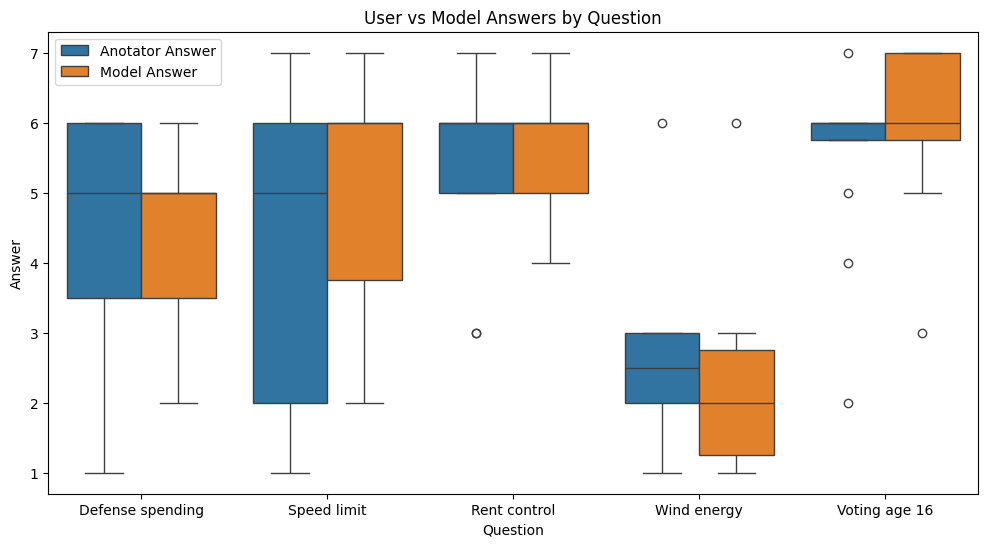

In [52]:
# grouped box-and-whisker plot of userAnswer and modelAnswer for each question

# transform question to shorter labels
# Auf einer Skala von 1 bis 7: Wie sehr stimmst du der Aussage zu: Auf allen Autobahnen soll ein generelles Tempolimit gelten. Antworte nur mit einer Zahl.' -> 
#  'Auf einer Skala von 1 bis 7: Wie sehr stimmst du der Aussage zu: Bei Bundestagswahlen sollen auch Jugendliche ab 16 Jahren wählen dürfen. Antworte nur mit einer Zahl.'
#  'Auf einer Skala von 1 bis 7: Wie sehr stimmst du der Aussage zu: Deutschland soll seine Verteidigungsausgaben erhöhen. Antworte nur mit einer Zahl.'
#  'Auf einer Skala von 1 bis 7: Wie sehr stimmst du der Aussage zu: Die Förderung von Windenergie soll beendet werden. Antworte nur mit einer Zahl.'
#  'Auf einer Skala von 1 bis 7: Wie sehr stimmst du der Aussage zu: Die Möglichkeiten der Vermieterinnen und Vermieter, Wohnungsmieten zu erhöhen, sollen gesetzlich stärker begrenzt werden. Antworte nur mit einer Zahl.']

QUESTIONS_SHORT_EN = [
    "Speed limit",
    "Defense spending",
    "Voting age 16",
    "Wind energy",
    "Rent control",
]

print(np.unique(df['question']))

question_mapping = {
    'Auf einer Skala von 1 bis 7: Wie sehr stimmst du der Aussage zu: Auf allen Autobahnen soll ein generelles Tempolimit gelten. Antworte nur mit einer Zahl.': QUESTIONS_SHORT_EN[0],
    'Auf einer Skala von 1 bis 7: Wie sehr stimmst du der Aussage zu: Deutschland soll seine Verteidigungsausgaben erhöhen. Antworte nur mit einer Zahl.': QUESTIONS_SHORT_EN[1],
    'Auf einer Skala von 1 bis 7: Wie sehr stimmst du der Aussage zu: Bei Bundestagswahlen sollen auch Jugendliche ab 16 Jahren wählen dürfen. Antworte nur mit einer Zahl.': QUESTIONS_SHORT_EN[2],
    'Auf einer Skala von 1 bis 7: Wie sehr stimmst du der Aussage zu: Die Förderung von Windenergie soll beendet werden. Antworte nur mit einer Zahl.': QUESTIONS_SHORT_EN[3],
    'Auf einer Skala von 1 bis 7: Wie sehr stimmst du der Aussage zu: Die Möglichkeiten der Vermieterinnen und Vermieter, Wohnungsmieten zu erhöhen, sollen gesetzlich stärker begrenzt werden. Antworte nur mit einer Zahl.': QUESTIONS_SHORT_EN[4],
}

df_plot = df.copy()

df_plot['question'] = df_plot['question'].map(question_mapping)


print(df_plot['question'].unique())
# change labels for plotting
# userAnswer -> Anotator Answer
# modelAnswer -> Model Answer




import seaborn as sns
melted_df = df_plot.melt(id_vars=['question'], value_vars=['userAnswer', 'modelAnswer'], var_name='source', value_name='answer')
# change plotting labels: userAnswer -> Anotator Answer, modelAnswer -> Model Answer
melted_df['source'] = melted_df['source'].map({
    'userAnswer': 'Anotator Answer',
    'modelAnswer': 'Model Answer'
})

plt.figure(figsize=(12, 6))
sns.boxplot(x='question', y='answer', hue='source', data=melted_df)
plt.xlabel('Question')
plt.ylabel('Answer')
plt.title('User vs Model Answers by Question')
plt.legend()
plt.savefig('figures/sanity_check_boxplot.pdf')

plt.show()


['Defense spending' 'Speed limit' 'Rent control' 'Wind energy'
 'Voting age 16']


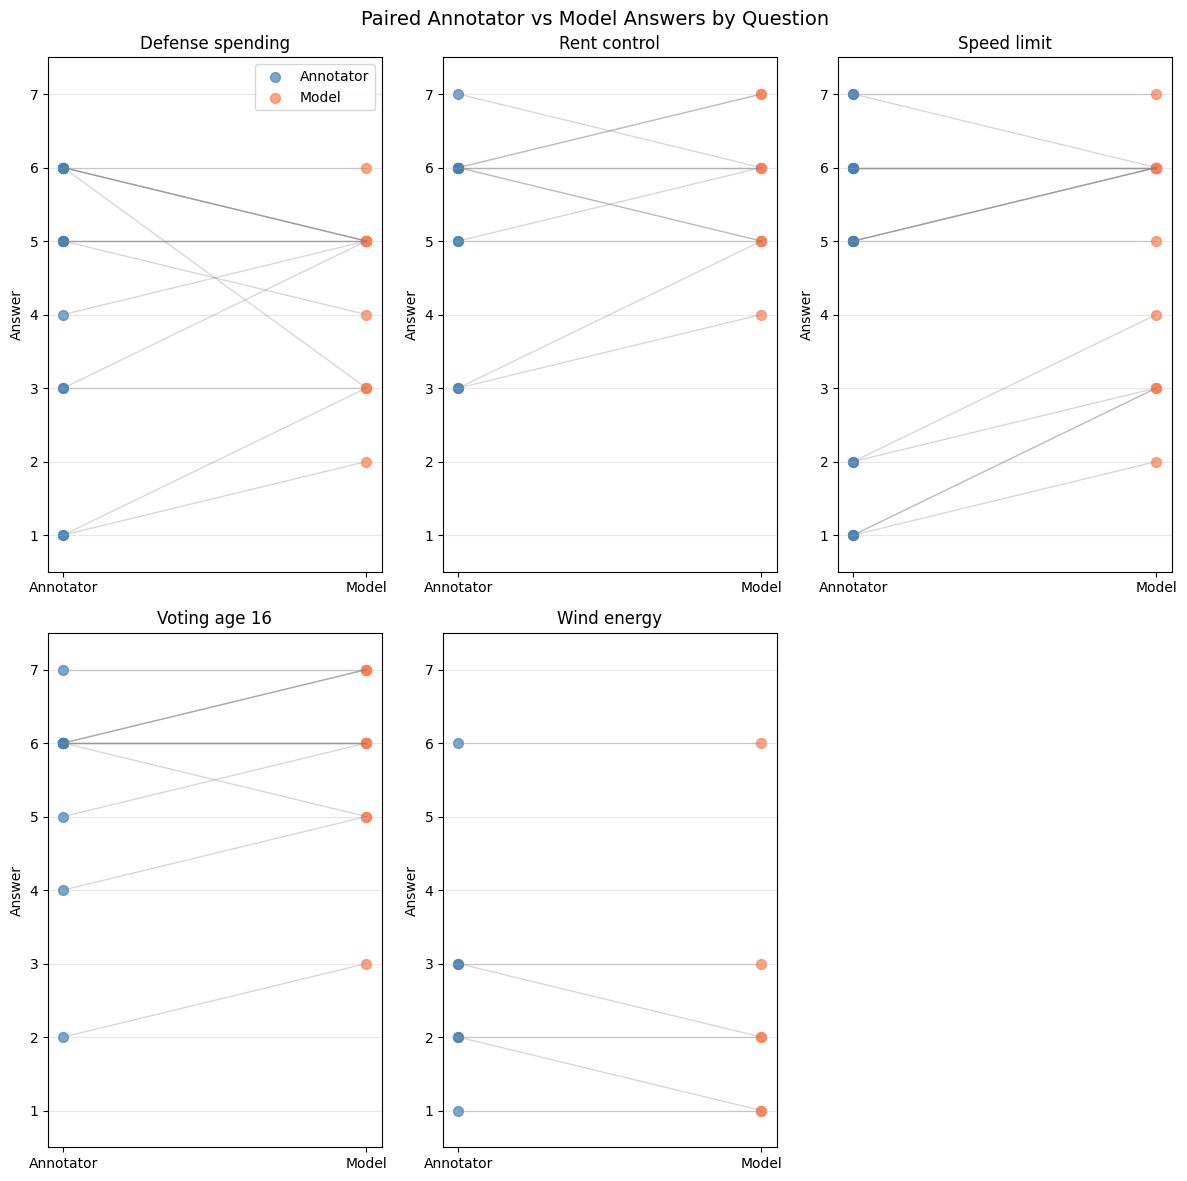

In [55]:
# Paired dot plot: connecting annotator and model answers for each observation

fig, axes = plt.subplots(2, 3, figsize=(12, 12))
fig.suptitle('Paired Annotator vs Model Answers by Question', fontsize=14)

print(df_plot['question'].unique())
questions_unique = sorted(df_plot['question'].unique())
axes_flat = axes.flatten()

for idx, question in enumerate(questions_unique):
    question_data = df_plot[df_plot['question'] == question].reset_index(drop=True)
    
    # Plot lines connecting userAnswer to modelAnswer
    for i, row in question_data.iterrows():
        axes_flat[idx].plot([0, 1], [row['userAnswer'], row['modelAnswer']], 
                       color='gray', alpha=0.3, linewidth=1)
    
    # Plot dots for annotator answers (left)
    axes_flat[idx].scatter([0] * len(question_data), question_data['userAnswer'], 
                     label='Annotator', alpha=0.7, s=50, color='steelblue')
    
    # Plot dots for model answers (right)
    axes_flat[idx].scatter([1] * len(question_data), question_data['modelAnswer'], 
                     label='Model', alpha=0.7, s=50, color='coral')
    
    axes_flat[idx].set_xticks([0, 1])
    axes_flat[idx].set_xticklabels(['Annotator', 'Model'])
    axes_flat[idx].set_ylabel('Answer')
    axes_flat[idx].set_title(question)
    axes_flat[idx].set_ylim(0.5, 7.5)
    axes_flat[idx].grid(axis='y', alpha=0.3)
    
    if idx == 0:
        axes_flat[idx].legend()

# Hide the empty subplot
axes_flat[-1].axis('off')

plt.tight_layout()
plt.savefig('figures/sanity_check_paired_plot.pdf')
plt.show()